In [1]:
!pip install tqdm
!pip install tensorflow_addons

     -------------------------------------- 755.8/755.8 KB 6.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [3]:
import os
tensorDir = 'output/v2'
signFiles = sorted(os.listdir(tensorDir))
print(signFiles)

['A.npy']


In [7]:
import numpy as np
import pandas as pd
import numpy as np
import os
  
tensor_map = {}
master_df = pd.DataFrame()

for signFile in signFiles:
    if signFile.endswith(".npy"):
        sign = os.path.splitext(signFile)[0]
        tensor_map[sign] = np.load(os.path.join(tensorDir, signFile))

        
#         output['tensors'].append(tensor)
#         output['labels'].append(sign)
        


In [8]:
count=0
label_map={}
sign_count = 0
for sign in tensor_map:
    sign_count = sign_count + np.shape(tensor_map[sign])[0]
    
combined=np.empty((sign_count, 63)) 
print(np.shape(combined))

index = 0
for sign in tensor_map:
    tensors = tensor_map[sign]
    for tensor in tensors:
        combined[index] = tensor
        label_map[index] = sign
        index = index + 1

(2180, 63)


# KMeans

In [6]:
from sklearn.cluster import DBSCAN, KMeans
clustering = KMeans(n_clusters=len(tensor_map.keys()), random_state=0).fit(combined)

In [6]:
print(clustering.labels_)

[ 3  0  2 ... 16  5 16]


In [7]:
print(len(clustering.labels_))

64050


In [8]:
sign_cluster_labels = {}
index = 0
for cluster_label in clustering.labels_:
    if cluster_label not in sign_cluster_labels:
        sign = label_map[index]
        sign_cluster_labels[cluster_label] = sign
    index = index + 1

In [9]:
# verify
num_matches=0
num_misses=0
for sign in tensor_map:
    tensors = tensor_map[sign]
    for tensor in tensors:
        prediction = clustering.predict(tensor.reshape(1, -1))[0]
        if sign_cluster_labels[prediction] == sign:
            num_matches = num_matches + 1
        else:
            num_misses = num_misses + 1
print("Accuracy " + str(num_matches / (num_matches + num_misses)))

Accuracy 0.045792349726775955


# Euclidean

In [16]:
center_points={}
max_points={}
min_points={}

for sign in tensor_map:
    tensors = tensor_map[sign]
    center_points[sign] = np.average(np.array(tensors), axis=0)
    max_points[sign] = np.max(np.array(tensors), axis=0)
    min_points[sign] = np.min(np.array(tensors), axis=0)


In [20]:
print(1 / len(tensor_map))

0.034482758620689655


In [19]:
def distance_to_center():
    # verify
    num_matches=0
    num_misses=0
    for sign in tensor_map:
        tensors = tensor_map[sign]
        for tensor in tensors:
            best_dist = None
            for sign in center_points:
                center_point = center_points[sign]
                dist = np.linalg.norm(center_point - tensor)
                if best_dist == None or dist < best_dist[1]:
                    best_dist = (sign, dist)
            if best_dist[0] == sign:
                num_matches = num_matches + 1
            else:
                num_misses = num_misses + 1
    return num_matches / (num_matches + num_misses)
    
print("Distance to center accuracy " + str(distance_to_center()))

Distance to center accuracy 0.08935206869633099


# Neural

In [9]:
# Import MINST data 
import tensorflow as tf 
import math

inputs=[]
outputs=[]

train_inputs = []
train_outputs = []
test_inputs = []
test_outputs = []

idx=0
sign_idx=0
num_signs = len(tensor_map);
signs=[]
for sign in tensor_map:
    signs.append(sign)
    tensor_idx = 0
    num_tensors = len(tensor_map[sign])
    train_test_split_idx = int(math.floor(0.8 * num_tensors))
    for tensor in tensor_map[sign]:
        inputs.append(tensor)
        outputs.append(sign_idx)
        
        if tensor_idx <= train_test_split_idx: 
            train_inputs.append(tensor)
            train_outputs.append(sign_idx)
        else:
            test_inputs.append(tensor)
            test_outputs.append(sign_idx)
        
        tensor_idx = tensor_idx + 1
    sign_idx = sign_idx + 1


# Convert to np
inputs = np.array(inputs)
outputs = np.array(outputs)
train_inputs = np.array(train_inputs)
train_outputs = np.array(train_outputs)
test_inputs = np.array(test_inputs)
test_outputs = np.array(test_outputs)


def get_sign_for_prediction(prediction):
    rounded_result = round(prediction[0])
    if rounded_result > 0 and rounded_result < len(signs):
        return signs[rounded_result]
    else:
        return None

def validate_neural(model):
        # verify
    num_matches=0
    num_misses=0
    for sign in tensor_map:
        tensors = tensor_map[sign]
        results = model.predict(tensors)        
        for result in results:
            rounded_result = round(result[0])
            if rounded_result > 0 and rounded_result < len(signs):
                sign_result = signs[rounded_result]
                if sign_result == sign:
                    num_matches = num_matches + 1
                else:
                    num_misses = num_misses + 1
            else:
                num_misses = num_misses + 1
    return num_matches / (num_matches + num_misses)

In [10]:
print(signs)

['A']


In [10]:
# accuracy ~55%
import tensorflow_addons as tfa
def neural_v1():
    callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress = False)]
    # model = tf.keras.models.Sequential([
    #   tf.keras.layers.InputLayer(input_shape=(63,)),
    #   tf.keras.layers.Dense(256, activation='relu'),
    #   tf.keras.layers.Dense(128, activation='relu'),
    #   tf.keras.layers.Dense(1)
    # ])
    # model.compile(
    #     optimizer=tf.keras.optimizers.Adam(0.001),
    # #     loss=tf.keras.losses.CosineSimilarity(
    # #         axis=-1,
    # # #         reduction=losses_utils.ReductionV2.AUTO,
    # #         name='cosine_similarity'
    # #     ),
    # #     loss=tf.keras.losses.MeanSquaredError(
    # # #         reduction=tf.keras.losses_utils.ReductionV2.AUTO,
    # #         name='mean_squared_error'
    # #     ),
    # #     metrics=[tf.keras.metrics.Accuracy()],
    #     loss = 'mean_squared_error'
    # )

    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
    #         return lr * tf.math.exp(-0.1)
            return lr
    callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))
    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(63,)),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.0001),
    #     loss=tf.keras.losses.CosineSimilarity(
    #         axis=-1,
    # #         reduction=losses_utils.ReductionV2.AUTO,
    #         name='cosine_similarity'
    #     ),
    #     loss=tf.keras.losses.MeanSquaredError(
    # #         reduction=tf.keras.losses_utils.ReductionV2.AUTO,
    #         name='mean_squared_error'
    #     ),
    #     metrics=[tf.keras.metrics.Accuracy()],
        loss = 'mean_squared_error'
    )


    print(np.shape(train_inputs))
    print(np.shape(train_outputs))
    # print("Train Examples: " + str(len(train_inputs)))
    # print("Train Output Examples: " + str(len(train_outputs)))
    # print("Test Examples: " + str(len(test_inputs)))
    # print("Test Output Examples: " + str(len(test_outputs)))
    model.fit(
        inputs,
        outputs,
        epochs=100,
        batch_size=64,
        verbose=0,
        validation_data=(inputs, outputs),
        callbacks=callbacks
    )

    return model
    # model.evaluate(
    #     inputs,
    #     outputs
    # )

In [11]:
# accuracy ~86%
import tensorflow_addons as tfa
def neural_v2():
    callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress = False)]

    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.01)
    callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))
    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(63,)),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss = 'mean_squared_error'
    )

    model.fit(
        inputs,
        outputs,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_data=(inputs, outputs),
        callbacks=callbacks
    )

    return model

In [12]:
# accuracy ~88%
import tensorflow_addons as tfa
def neural_v3():
    callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress = False)]

    def scheduler(epoch, lr):
        if epoch < 20:
            return lr
        elif epoch < 50:
            return lr * tf.math.exp(-0.1)
        else:
            return lr * tf.math.exp(-0.01)
    callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))
    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(63,)),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss = 'mean_squared_error'
    )

    model.fit(
        inputs,
        outputs,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_data=(inputs, outputs),
        callbacks=callbacks
    )

    return model

In [13]:
# accuracy ~96%
import tensorflow_addons as tfa
def neural_v4():
    callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress = False)]

    def scheduler(epoch, lr):
        if epoch < 20:
            return lr
        elif epoch < 50:
            return lr * tf.math.exp(-0.1)
        else:
            return lr * tf.math.exp(-0.01)
    callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))
    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(63,)),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss = 'mean_squared_error'
    )

    model.fit(
        inputs,
        outputs,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_data=(inputs, outputs),
        callbacks=callbacks
    )

    return model

In [14]:
# accuracy ~95%
import tensorflow_addons as tfa
def neural_v5():
    callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress = False)]

    def scheduler(epoch, lr):
        if epoch < 20:
            return lr
        elif epoch < 50:
            return lr * tf.math.exp(-0.1)
        else:
            return lr * tf.math.exp(-0.01)
    callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))
    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(63,)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss = 'mean_squared_error'
    )

    model.fit(
        inputs,
        outputs,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_data=(inputs, outputs),
        callbacks=callbacks
    )

    return model

In [15]:
# accuracy ~92%
import tensorflow_addons as tfa
def neural_v6():
    callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress = False)]

    def scheduler(epoch, lr):
        if epoch < 20:
            return lr
        elif epoch < 50:
            return lr * tf.math.exp(-0.1)
        else:
            return lr * tf.math.exp(-0.01)
    callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))
    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(63,)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss = 'mean_squared_error'
    )

    model.fit(
        inputs,
        outputs,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_data=(inputs, outputs),
        callbacks=callbacks
    )

    return model

In [16]:
# accuracy ~95%
import tensorflow_addons as tfa
def neural_v7():
    callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress = False)]

    def scheduler(epoch, lr):
        if epoch < 20:
            return lr
        elif epoch < 50:
            return lr * tf.math.exp(-0.1)
        else:
            return lr * tf.math.exp(-0.01)
    callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))
    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(63,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss = 'mean_squared_error'
    )

    model.fit(
        inputs,
        outputs,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_data=(inputs, outputs),
        callbacks=callbacks
    )

    return model

In [17]:
# accuracy ~95%
import tensorflow_addons as tfa
def neural_v8():
    train_inputs = np.array(inputs)
    train_outputs = np.array(outputs)
    test_inputs = np.array(inputs)
    test_outputs = np.array(outputs)

    callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress = False)]

    def scheduler(epoch, lr):
        if epoch < 20:
            return lr
        elif epoch < 50:
            return lr * tf.math.exp(-0.1)
        else:
            return lr * tf.math.exp(-0.01)
    callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))
    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(63,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss = 'mean_squared_error'
    )

    model.fit(
        train_inputs,
        train_outputs,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_data=(test_inputs, test_outputs),
        callbacks=callbacks
    )

    return model

In [11]:
# accuracy ~94%
import tensorflow_addons as tfa
def neural_v9():
    callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress = False)]

    def scheduler(epoch, lr):
        if epoch < 20:
            return lr
        elif epoch < 50:
            return lr * tf.math.exp(-0.1)
        else:
            return lr * tf.math.exp(-0.01)
    callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))
    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(63,)),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss = 'mean_squared_error'
    )

    model.fit(
        train_inputs,
        train_outputs,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_data=(test_inputs, test_outputs),
        callbacks=callbacks
    )

    return model

In [13]:
import tensorflowjs as tfjs

# model = neural_v1()
model = neural_v9()
print("Accuracy: " + str(validate_neural(model)))

tfjs.converters.save_keras_model(model, 'output/model/v9')

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


Training:   1%|           1/100 ETA: 01:03s,   1.56epochs/s

Epoch 2/100


Training:   2%|▏          2/100 ETA: 00:36s,   2.65epochs/s

Epoch 3/100


Training:   3%|▎          3/100 ETA: 00:28s,   3.45epochs/s

Epoch 4/100


Training:   4%|▍          4/100 ETA: 00:23s,   4.14epochs/s

Epoch 5/100


Training:   5%|▌          5/100 ETA: 00:20s,   4.57epochs/s

Epoch 6/100


Training:   6%|▌          6/100 ETA: 00:18s,   5.00epochs/s

Epoch 7/100


Training:   7%|▋          7/100 ETA: 00:17s,   5.29epochs/s

Epoch 8/100


Training:   8%|▊          8/100 ETA: 00:16s,   5.57epochs/s

Epoch 9/100


Training:   9%|▉          9/100 ETA: 00:17s,   5.22epochs/s

Epoch 10/100


Training:  10%|█          10/100 ETA: 00:16s,   5.42epochs/s

Epoch 11/100


Training:  11%|█          11/100 ETA: 00:15s,   5.68epochs/s

Epoch 12/100


Training:  12%|█▏         12/100 ETA: 00:15s,   5.76epochs/s

Epoch 13/100


Training:  13%|█▎         13/100 ETA: 00:15s,   5.77epochs/s

Epoch 14/100


Training:  14%|█▍         14/100 ETA: 00:14s,   5.77epochs/s

Epoch 15/100


Training:  15%|█▌         15/100 ETA: 00:14s,   5.89epochs/s

Epoch 16/100


Training:  16%|█▌         16/100 ETA: 00:14s,   5.91epochs/s

Epoch 17/100


Training:  17%|█▋         17/100 ETA: 00:14s,   5.92epochs/s

Epoch 18/100


Training:  18%|█▊         18/100 ETA: 00:14s,   5.77epochs/s

Epoch 19/100


Training:  19%|█▉         19/100 ETA: 00:14s,   5.71epochs/s

Epoch 20/100


Training:  20%|██         20/100 ETA: 00:13s,   5.72epochs/s

Epoch 21/100


Training:  21%|██         21/100 ETA: 00:13s,   5.65epochs/s

Epoch 22/100


Training:  22%|██▏        22/100 ETA: 00:13s,   5.61epochs/s

Epoch 23/100


Training:  23%|██▎        23/100 ETA: 00:13s,   5.73epochs/s

Epoch 24/100


Training:  24%|██▍        24/100 ETA: 00:13s,   5.75epochs/s

Epoch 25/100


Training:  25%|██▌        25/100 ETA: 00:13s,   5.76epochs/s

Epoch 26/100


Training:  26%|██▌        26/100 ETA: 00:12s,   5.71epochs/s

Epoch 27/100


Training:  27%|██▋        27/100 ETA: 00:12s,   5.74epochs/s

Epoch 28/100


Training:  28%|██▊        28/100 ETA: 00:13s,   5.44epochs/s

Epoch 29/100


Training:  29%|██▉        29/100 ETA: 00:14s,   5.04epochs/s

Epoch 30/100


Training:  30%|███        30/100 ETA: 00:13s,   5.05epochs/s

Epoch 31/100


Training:  31%|███        31/100 ETA: 00:13s,   5.14epochs/s

Epoch 32/100


Training:  32%|███▏       32/100 ETA: 00:13s,   5.12epochs/s

Epoch 33/100


Training:  33%|███▎       33/100 ETA: 00:12s,   5.23epochs/s

Epoch 34/100


Training:  34%|███▍       34/100 ETA: 00:12s,   5.36epochs/s

Epoch 35/100


Training:  35%|███▌       35/100 ETA: 00:12s,   5.13epochs/s

Epoch 36/100


Training:  36%|███▌       36/100 ETA: 00:13s,   4.89epochs/s

Epoch 37/100


Training:  37%|███▋       37/100 ETA: 00:12s,   5.01epochs/s

Epoch 38/100


Training:  38%|███▊       38/100 ETA: 00:12s,   4.99epochs/s

Epoch 39/100


Training:  39%|███▉       39/100 ETA: 00:11s,   5.34epochs/s

Epoch 40/100


Training:  40%|████       40/100 ETA: 00:11s,   5.45epochs/s

Epoch 41/100


Training:  41%|████       41/100 ETA: 00:10s,   5.64epochs/s

Epoch 42/100


Training:  42%|████▏      42/100 ETA: 00:10s,   5.59epochs/s

Epoch 43/100


Training:  43%|████▎      43/100 ETA: 00:10s,   5.54epochs/s

Epoch 44/100


Training:  44%|████▍      44/100 ETA: 00:10s,   5.44epochs/s

Epoch 45/100


Training:  45%|████▌      45/100 ETA: 00:10s,   5.38epochs/s

Epoch 46/100


Training:  46%|████▌      46/100 ETA: 00:09s,   5.44epochs/s

Epoch 47/100


Training:  47%|████▋      47/100 ETA: 00:09s,   5.39epochs/s

Epoch 48/100


Training:  48%|████▊      48/100 ETA: 00:09s,   5.34epochs/s

Epoch 49/100


Training:  49%|████▉      49/100 ETA: 00:09s,   5.35epochs/s

Epoch 50/100


Training:  50%|█████      50/100 ETA: 00:09s,   5.35epochs/s

Epoch 51/100


Training:  51%|█████      51/100 ETA: 00:08s,   5.48epochs/s

Epoch 52/100


Training:  52%|█████▏     52/100 ETA: 00:08s,   5.47epochs/s

Epoch 53/100


Training:  53%|█████▎     53/100 ETA: 00:08s,   5.38epochs/s

Epoch 54/100


Training:  54%|█████▍     54/100 ETA: 00:08s,   5.49epochs/s

Epoch 55/100


Training:  55%|█████▌     55/100 ETA: 00:08s,   5.36epochs/s

Epoch 56/100


Training:  56%|█████▌     56/100 ETA: 00:08s,   5.41epochs/s

Epoch 57/100


Training:  57%|█████▋     57/100 ETA: 00:07s,   5.53epochs/s

Epoch 58/100


Training:  58%|█████▊     58/100 ETA: 00:07s,   5.46epochs/s

Epoch 59/100


Training:  59%|█████▉     59/100 ETA: 00:07s,   5.38epochs/s

Epoch 60/100


Training:  60%|██████     60/100 ETA: 00:07s,   5.04epochs/s

Epoch 61/100


Training:  61%|██████     61/100 ETA: 00:08s,   4.71epochs/s

Epoch 62/100


Training:  62%|██████▏    62/100 ETA: 00:08s,   4.34epochs/s

Epoch 63/100


Training:  63%|██████▎    63/100 ETA: 00:08s,   4.14epochs/s

Epoch 64/100


Training:  64%|██████▍    64/100 ETA: 00:08s,   4.02epochs/s

Epoch 65/100


Training:  65%|██████▌    65/100 ETA: 00:08s,   3.93epochs/s

Epoch 66/100


Training:  66%|██████▌    66/100 ETA: 00:08s,   3.98epochs/s

Epoch 67/100


Training:  67%|██████▋    67/100 ETA: 00:08s,   3.91epochs/s

Epoch 68/100


Training:  68%|██████▊    68/100 ETA: 00:08s,   3.90epochs/s

Epoch 69/100


Training:  69%|██████▉    69/100 ETA: 00:07s,   3.94epochs/s

Epoch 70/100


Training:  70%|███████    70/100 ETA: 00:07s,   3.98epochs/s

Epoch 71/100


Training:  71%|███████    71/100 ETA: 00:07s,   3.97epochs/s

Epoch 72/100


Training:  72%|███████▏   72/100 ETA: 00:07s,   3.97epochs/s

Epoch 73/100


Training:  73%|███████▎   73/100 ETA: 00:06s,   3.95epochs/s

Epoch 74/100


Training:  74%|███████▍   74/100 ETA: 00:06s,   3.86epochs/s

Epoch 75/100


Training:  75%|███████▌   75/100 ETA: 00:06s,   3.83epochs/s

Epoch 76/100


Training:  76%|███████▌   76/100 ETA: 00:06s,   3.84epochs/s

Epoch 77/100


Training:  77%|███████▋   77/100 ETA: 00:05s,   3.90epochs/s

Epoch 78/100


Training:  78%|███████▊   78/100 ETA: 00:05s,   3.88epochs/s

Epoch 79/100


Training:  79%|███████▉   79/100 ETA: 00:05s,   3.89epochs/s

Epoch 80/100


Training:  80%|████████   80/100 ETA: 00:05s,   3.93epochs/s

Epoch 81/100


Training:  81%|████████   81/100 ETA: 00:04s,   4.04epochs/s

Epoch 82/100


Training:  82%|████████▏  82/100 ETA: 00:04s,   4.04epochs/s

Epoch 83/100


Training:  83%|████████▎  83/100 ETA: 00:04s,   4.04epochs/s

Epoch 84/100


Training:  84%|████████▍  84/100 ETA: 00:03s,   4.02epochs/s

Epoch 85/100


Training:  85%|████████▌  85/100 ETA: 00:03s,   3.99epochs/s

Epoch 86/100


Training:  86%|████████▌  86/100 ETA: 00:03s,   3.95epochs/s

Epoch 87/100


Training:  87%|████████▋  87/100 ETA: 00:03s,   4.03epochs/s

Epoch 88/100


Training:  88%|████████▊  88/100 ETA: 00:03s,   3.92epochs/s

Epoch 89/100


Training:  89%|████████▉  89/100 ETA: 00:02s,   3.80epochs/s

Epoch 90/100


Training:  90%|█████████  90/100 ETA: 00:02s,   3.75epochs/s

Epoch 91/100


Training:  91%|█████████  91/100 ETA: 00:02s,   3.80epochs/s

Epoch 92/100


Training:  92%|█████████▏ 92/100 ETA: 00:02s,   3.78epochs/s

Epoch 93/100


Training:  93%|█████████▎ 93/100 ETA: 00:01s,   3.86epochs/s

Epoch 94/100


Training:  94%|█████████▍ 94/100 ETA: 00:01s,   3.97epochs/s

Epoch 95/100


Training:  95%|█████████▌ 95/100 ETA: 00:01s,   4.02epochs/s

Epoch 96/100


Training:  96%|█████████▌ 96/100 ETA: 00:00s,   4.09epochs/s

Epoch 97/100


Training:  97%|█████████▋ 97/100 ETA: 00:00s,   4.10epochs/s

Epoch 98/100


Training:  98%|█████████▊ 98/100 ETA: 00:00s,   4.09epochs/s

Epoch 99/100


Training:  99%|█████████▉ 99/100 ETA: 00:00s,   4.19epochs/s

Epoch 100/100


Training: 100%|██████████ 100/100 ETA: 00:00s,   4.64epochs/s


Accuracy: 0.0


In [18]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'output/neural_model_v4')

# Testing

J


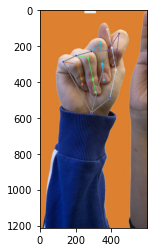

In [32]:
import os
import cv2
import tensorflow as tf
import mediapipe as mp
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.01) as hands:

    file = os.path.join('tigers.jpg')
    image = cv2.imread(file)
#     image = cv2.flip(image, 1)
    # Convert the BGR image to RGB before processing.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # crop out title
    image = image[400:]
    image = image[:,0:600]


    plt.imshow(image)
    
    results = hands.process(image)
#     print(results.multi_hand_landmarks)

    image_height, image_width, _ = image.shape
    annotated_image = image.copy()
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
        index = 0
        tensor = np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]).flatten()
        plt.imshow(annotated_image)
        print(get_sign_for_prediction(model.predict(np.array([tensor]))[0]))
